In [1]:
from srsinst.sr860 import SR860

In [2]:
import pyvisa as visa 

In [3]:
lockin = SR860('vxi11', '192.168.0.4')

Stanford_Research_Systems,SR865A,004198,V1.51


In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [5]:
lockin.signal.filter_slope = 18       # dB/oct
lockin.signal.advanced_filter = 'off' # or 'on'

# Wait ~5×tau for ~99% settling (SR860 manual guidance)
wait_time_s = lockin.signal.time_constant
print(f"Time/measurement = {wait_time_s} s")

Time/measurement = 1.0 s


Opened magnet on COM3
IDN: b'*IDN?\r\nCryomagnetics,4G,8281,1.67,327\r\n'
UNITS? -> b'UNITS?\r\nA\r\n'

Bipolar loop: -0.1500 T → 0.1500 T → -0.1500 T
Currents: -2.3155 A → 2.3155 A → -2.3155 A

=== PRE: move to ~ -B_max (logging) ===
PRE: t=  0.0s  B= 0.00000T  R= 1.185758e-07
PRE: t=  0.7s  B= 0.00010T  R= 1.192683e-07
PRE: t=  1.3s  B= 0.00005T  R= 1.204053e-07
PRE: t=  1.9s  B=-0.01785T  R= 1.215312e-07
PRE: t=  2.5s  B=-0.04997T  R= 1.218136e-07
PRE: t=  3.1s  B=-0.05445T  R= 1.216808e-07
PRE: t=  3.7s  B=-0.07201T  R= 1.208189e-07
PRE: t=  4.3s  B=-0.08915T  R= 1.203409e-07
PRE: t=  4.9s  B=-0.10613T  R= 1.208234e-07
PRE: t=  5.5s  B=-0.11967T  R= 1.213029e-07
PRE: t=  6.1s  B=-0.12078T  R= 1.217627e-07
PRE: t=  6.7s  B=-0.12304T  R= 1.226840e-07
PRE: t=  7.3s  B=-0.12998T  R= 1.236005e-07
PRE: t=  7.9s  B=-0.13196T  R= 1.244239e-07
PRE: t=  8.5s  B=-0.13417T  R= 1.249781e-07
PRE: t=  9.1s  B=-0.13625T  R= 1.244994e-07
PRE: t=  9.7s  B=-0.13797T  R= 1.240345e-07
PRE: t= 10.3s  B=

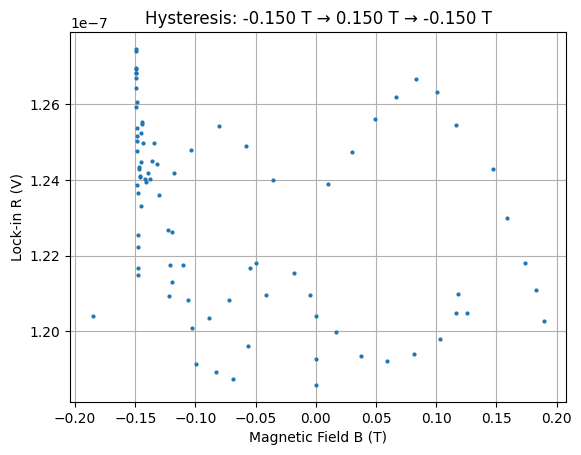


=== FINAL: Sweeping to ~0 T ===
Returning to zero... B = -0.197009 T
Returning to zero... B = -0.163718 T
Returning to zero... B = -0.148197 T
Returning to zero... B = -0.135980 T
Returning to zero... B = -0.138610 T
Returning to zero... B = -0.123088 T
Returning to zero... B = -0.105617 T
Returning to zero... B = -0.091910 T
Returning to zero... B = -0.076810 T
Returning to zero... B = -0.061217 T
Returning to zero... B = -0.044497 T
Returning to zero... B = -0.026080 T
Returning to zero... B = -0.015618 T
Returning to zero... B = 0.036724 T
Returning to zero... B = 0.036724 T
Returning to zero... B = 0.060641 T
Returning to zero... B = 0.038784 T
Returning to zero... B = 0.043318 T
Returning to zero... B = 0.036568 T
Returning to zero... B = 0.032416 T
Returning to zero... B = 0.031386 T
Returning to zero... B = 0.029332 T
Returning to zero... B = 0.026152 T
Returning to zero... B = 0.022278 T
Returning to zero... B = -0.028892 T
Returning to zero... B = -0.027337 T
Returning to zer

In [25]:
import serial
import time
import re
import matplotlib.pyplot as plt

# ---------- MAGNET SETTINGS ----------
coil_constant = 0.06478    # T/A  <-- your coil constant
MAX_CURRENT_A = 12.0       # keep within ±2 A alarm limits


# ---------- BASIC MAGNET HELPERS ----------
def send_cmd(ser, cmd, read_bytes=0):
    """
    Send a command (without terminator) to the 4G and optionally read back.
    4G uses carriage return '\\r' as the terminator.
    """
    ser.reset_input_buffer()
    ser.write((cmd + "\r").encode("ascii"))
    time.sleep(0.05)
    if read_bytes > 0:
        return ser.read(read_bytes)
    return b""


def read_field_T(ser, coil_const=coil_constant):
    """
    Ask IMAG? and convert reply to Tesla.
    Handles '0.0000A', '0.123kG', '0.001 T', etc.
    """
    ser.reset_input_buffer()
    ser.write(b"IMAG?\r")
    time.sleep(0.05)

    last_line = b""

    for _ in range(10):
        line = ser.readline()
        if not line:
            continue

        last_line = line
        text = line.decode(errors="ignore").strip()
        if not text:
            continue

        # parse numeric value + optional unit stuck on the end
        m = re.match(r"\s*([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)([a-zA-Z]*)", text)
        if not m:
            continue

        value = float(m.group(1))
        unit = m.group(2).lower()   # 'a', 'kg', 'g', 't', or ''

        if unit.startswith("a"):         # Amps → Tesla
            return value * coil_const
        elif unit.startswith("t"):       # Tesla
            return value
        elif "kg" in unit:              # kiloGauss
            return value * 0.1          # 1 kG = 0.1 T
        elif unit.endswith("g"):        # Gauss
            return value * 1e-4         # 1 G = 1e-4 T
        else:
            # unknown / no unit: assume Tesla
            return value

    raise RuntimeError(f"No numeric IMAG? found, last line: {last_line!r}")


def set_sweep_limits(ser, I_low_A, I_high_A):
    """
    Program sweep lower and upper limits in Amps.
    (UNITS on the 4G must be A.)
    """
    send_cmd(ser, f"LLIM {I_low_A:.4f}")
    send_cmd(ser, f"ULIM {I_high_A:.4f}")


# ---------- LOCK-IN HELPER ----------
def read_lockin_R_X_Y_Theta(lockin):
    """
    Uses your SR865 Python object:
        X, Y, R, Theta = lockin.data.get_channel_values()
    """
    X, Y, R, Theta = lockin.data.get_channel_values()
    return X, Y, R, Theta


# ---------- BIPOLAR LOOP: -Bmax → +Bmax → -Bmax ----------
def hysteresis_bipolar(
    mag_ser,
    lockin,
    B_max,
    dt=0.5,
    tol_T=0.0005,
    max_time_per_branch_s=120,
    coil_const=coil_constant,
):
    """
    Bipolar hysteresis loop:

      PRE:  current B -> -B_max   (logged)
      UP:   -B_max    -> +B_max   (logged)
      DOWN: +B_max    -> -B_max   (logged)

    All segments are recorded in B_list, R_list, etc.
    """

    # 1) Put magnet in REMOTE and Amps mode
    send_cmd(mag_ser, "REMOTE")
    send_cmd(mag_ser, "UNITS A")
    print("UNITS? ->", send_cmd(mag_ser, "UNITS?", read_bytes=40))

    B_min = -abs(B_max)
    B_max = abs(B_max)

    # 2) Convert to currents
    I_min = B_min / coil_const   # negative
    I_max = B_max / coil_const   # positive

    # Safety: obey ±MAX_CURRENT_A
    for I in (I_min, I_max):
        if abs(I) > MAX_CURRENT_A:
            raise ValueError(
                f"Requested current {I:.3f} A exceeds ±{MAX_CURRENT_A:.3f} A limit"
            )

    print(f"\nBipolar loop: {B_min:.4f} T → {B_max:.4f} T → {B_min:.4f} T")
    print(f"Currents: {I_min:.4f} A → {I_max:.4f} A → {I_min:.4f} A")

    # 3) Set sweep limits once for full bipolar range
    set_sweep_limits(mag_ser, I_low_A=I_min, I_high_A=I_max)

    # Data arrays
    B_list = []
    R_list = []
    X_list = []
    Y_list = []
    Theta_list = []

    # ---------- PREPOSITION: move to ~-B_max (logged) ----------
    print("\n=== PRE: move to ~ -B_max (logging) ===")
    B_now = read_field_T(mag_ser, coil_const)
    if B_now > B_min:
        send_cmd(mag_ser, "SWEEP DOWN")
    else:
        send_cmd(mag_ser, "SWEEP UP")

    t0 = time.time()
    while True:
        t = time.time() - t0
        B = read_field_T(mag_ser, coil_const)
        X, Y, R, Th = read_lockin_R_X_Y_Theta(lockin)

        B_list.append(B)
        R_list.append(R)
        X_list.append(X)
        Y_list.append(Y)
        Theta_list.append(Th)

        print(f"PRE: t={t:5.1f}s  B={B: .5f}T  R={R: .6e}")

        if (B <= B_min + tol_T) or (t >= max_time_per_branch_s):
            break
        time.sleep(dt)

    send_cmd(mag_ser, "SWEEP PAUSE")
    print("Reached near -B_max, starting UP branch...\n")

    # ---------- UP: -B_max → +B_max ----------
    print("=== UP branch: -B_max → +B_max ===")
    send_cmd(mag_ser, "SWEEP UP")
    print("SWEEP? ->", send_cmd(mag_ser, "SWEEP?", read_bytes=40))

    t0 = time.time()
    while True:
        t = time.time() - t0
        B = read_field_T(mag_ser, coil_const)
        X, Y, R, Th = read_lockin_R_X_Y_Theta(lockin)

        B_list.append(B)
        R_list.append(R)
        X_list.append(X)
        Y_list.append(Y)
        Theta_list.append(Th)

        print(f"UP:  t={t:5.1f}s  B={B: .5f}T  R={R: .6e}")

        if (B >= B_max - tol_T) or (t >= max_time_per_branch_s):
            break
        time.sleep(dt)

    send_cmd(mag_ser, "SWEEP PAUSE")
    print("Reached near +B_max, starting DOWN branch...\n")

    # ---------- DOWN: +B_max → -B_max ----------
    print("=== DOWN branch: +B_max → -B_max ===")
    send_cmd(mag_ser, "SWEEP DOWN")
    print("SWEEP? ->", send_cmd(mag_ser, "SWEEP?", read_bytes=40))

    t0 = time.time()
    while True:
        t = time.time() - t0
        B = read_field_T(mag_ser, coil_const)
        X, Y, R, Th = read_lockin_R_X_Y_Theta(lockin)

        B_list.append(B)
        R_list.append(R)
        X_list.append(X)
        Y_list.append(Y)
        Theta_list.append(Th)

        print(f"DOWN:t={t:5.1f}s  B={B: .5f}T  R={R: .6e}")

        if (B <= B_min + tol_T) or (t >= max_time_per_branch_s):
            break
        time.sleep(dt)

    send_cmd(mag_ser, "SWEEP PAUSE")

    # ---------- Plot R vs B (in volts, with dots) ----------
    plt.figure()
    plt.plot(B_list, R_list, ".", markersize=4)
    plt.xlabel("Magnetic Field B (T)")
    plt.ylabel("Lock-in R (V)")
    plt.title(f"Hysteresis: {B_min:.3f} T → {B_max:.3f} T → {B_min:.3f} T")
    plt.grid(True)
    plt.show()

    # ---------- FINAL: return to ~0 T ----------
    print("\n=== FINAL: Sweeping to ~0 T ===")

    send_cmd(mag_ser, "SWEEP PAUSE")   # stop any previous sweep
    send_cmd(mag_ser, "UNITS A")

    # temporarily set limits around 0 A (safe small window)
    send_cmd(mag_ser, "LLIM -0.10")
    send_cmd(mag_ser, "ULIM 0.10")

    # Use the 4G's built-in zero-sweep, if supported by your firmware
    # (this is a standard Cryomagnetics 4G command)
    send_cmd(mag_ser, "SWEEP ZERO")

    t0 = time.time()
    while True:
        B = read_field_T(mag_ser, coil_const)
        print(f"Returning to zero... B = {B:.6f} T")

        if abs(B) < tol_T:   # same tolerance as branches (e.g. 0.5 mT)
            break
        if time.time() - t0 > max_time_per_branch_s:
            print("Timeout returning to ~0 T.")
            break

        time.sleep(dt)

    send_cmd(mag_ser, "SWEEP PAUSE")
    print("Finished near 0 T.\n")

    return {
        "B": B_list,
        "R": R_list,
        "X": X_list,
        "Y": Y_list,
        "Theta": Theta_list,
    }


# ---------- MAIN: OPEN MAGNET, RUN LOOP, CLOSE ----------
PORT = "COM3"
BAUD = 9600
TIMEOUT = 1.0   # seconds

mag_ser = serial.Serial(
    port=PORT,
    baudrate=BAUD,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=TIMEOUT,
)

print("Opened magnet on", PORT)
mag_ser.reset_input_buffer()
mag_ser.write(b"*IDN?\r")
time.sleep(0.2)
print("IDN:", mag_ser.read(200))

# 🔴 Make sure your SR865 lock-in object exists:
# from srsinst.sr865 import SR865
# lockin = SR865("TCPIP::xxx.xxx.xxx.xxx::INSTR")

# Example: ±0.1 T loop
B_max_loop = 0.15   # Tesla

data = hysteresis_bipolar(
    mag_ser=mag_ser,
    lockin=lockin,
    B_max=B_max_loop,
    dt=0.5,
    tol_T=0.0005,
    max_time_per_branch_s=30,
)

mag_ser.close()
print("Magnet serial closed.")


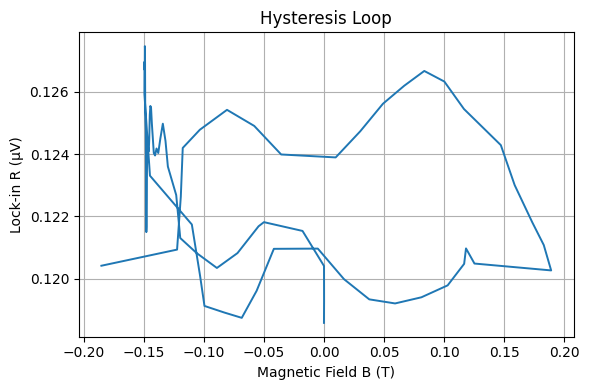

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists → numpy arrays (optional but cleaner)
B = np.array(data["B"])
R = np.array(data["R"]) * 1e6    # V → µV

plt.figure(figsize=(6,4))
plt.plot(B, R, '-', linewidth=1.4)   # line plot (no dots)
plt.xlabel("Magnetic Field B (T)")
plt.ylabel("Lock-in R (µV)")
plt.title("Hysteresis Loop")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:

num_points = 100                  # set 100 for a longer sweep
offset = np.linspace(-1.0, 1.0, num=num_points)  # example: sweep -1 V to +1 V

X, Y, R, Theta = [], [], [], []
t_elapsed = []

# Start with initial DC offset; give one full settle
lockin.ref.sine_out_offset = float(offset[0])
time.sleep(wait_time_s)

t0 = time.monotonic()

for vdc in offset:
    lockin.ref.sine_out_offset = float(vdc)
    time.sleep(wait_time_s)  # allow lock-in to settle

    # Read channels (X, Y, R, Theta)
    x, y, r, theta = lockin.data.get_channel_values()
    X.append(x); Y.append(y); R.append(r); Theta.append(theta)

    # Real elapsed time from start (seconds)
    t_elapsed.append(time.monotonic() - t0)

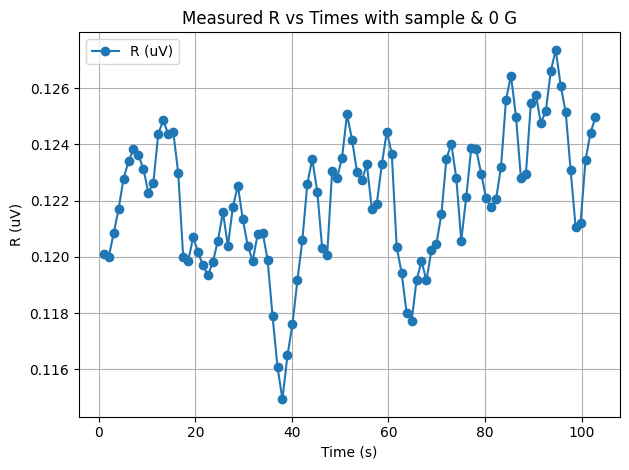

In [21]:
R_uV = np.array(R) * 1e6
plt.figure()
plt.plot(t_elapsed, R_uV, marker='o', label='R (uV)')
plt.xlabel('Time (s)')
plt.ylabel('R (uV)')

plt.title('Measured R vs Times with sample & 0 G')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

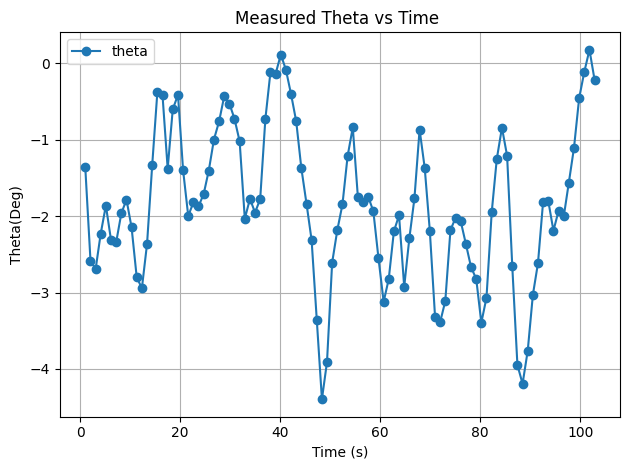

In [22]:
plt.plot(t_elapsed, Theta, marker='o', label='theta')
plt.xlabel('Time (s)')
plt.ylabel('Theta(Deg)')
plt.title('Measured Theta vs Time ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

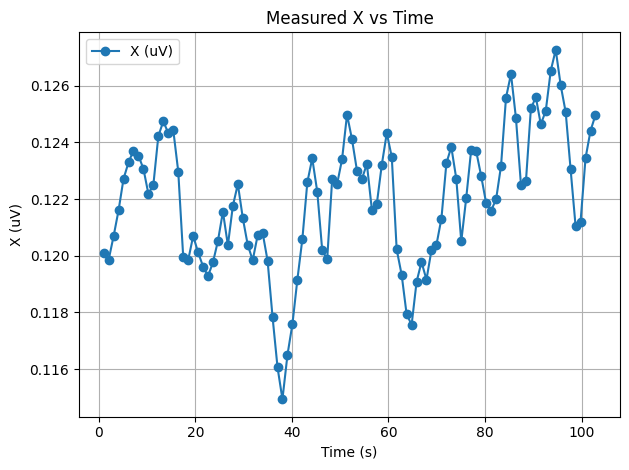

In [23]:
X_uV = np.array(X) * 1e6
plt.figure()
plt.plot(t_elapsed, X_uV, marker='o', label='X (uV)')
plt.xlabel('Time (s)')
plt.ylabel('X (uV)')
plt.title('Measured X vs Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
Y_uV = np.array(Y) * 1e6
plt.figure()
plt.plot(t_elapsed, Y_uV, marker='o', label='Y (uV)')
plt.xlabel('Time (s)')
plt.ylabel('Y (uV)')
plt.title('Measured Y vs Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()